Часть 1. Получение данных архива погоды сподготовленного csv файла.
Анализ датасета

In [ ]:
!pip install fastapi
!pip install kaleido
!pip install uvicorn
!pip install python-multipart
!pip install plotly --upgrade
!pip install optuna
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats as sc
import seaborn as sbn
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from math import sqrt
import math
import datetime as dt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import optuna
from catboost import CatBoostRegressor

data = pd.read_csv('https://raw.githubusercontent.com/bertImaev/innopolis/main/attestation/final_work/weather3.csv', sep='#')
print('Размер датасета: ', data.shape)

Размер датасета:  (27672, 29)


Визуализация графика температуры

In [ ]:
init_notebook_mode(connected = True)
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['date_time'], y=data['T'], name='Суточные значения'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor='center'),
                  title='График температуры',
                  xaxis_title='Температура',
                  yaxis_title="оС",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show(renderer='colab')

In [ ]:
# # Расшифровка наименования столбцов
# import requests as rq
# from bs4 import BeautifulSoup
# url = 'http://rp5.ru/archive.php?wmo_id=28606&lang=ru'
# resp = rq.get(url)
# soup = BeautifulSoup(resp.content, 'html.parser')
# tr = soup.select('#archiveTable tr')[0]
# for td in tr.select('td'):
#   print(td.get_text(strip=True).replace('Дата/ Местное время', 'date_time') + '\t' + td['onmouseover'].split(',')[1].strip())

In [ ]:
# для дальнейшей работы будем использовать следующие поля датасета
# Поля и наименования для работы
c_name = {"date_time": "Время в данном населённом пункте. Учитывается летнее/зимнее время",
"T": "Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли",
"Po": "Атмосферное давление на уровне станции (миллиметры ртутного столба)",
"P": "Атмосферное давление",
"U": "Относительная влажность (%) на высоте 2 метра над поверхностью земли",
"DD": "Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью",
"Ff": "Cкорость ветра на высоте 10-12 метров над земной поверхностью",
"N": "Общая облачность",
"WW": "Текущая погода",
"Td": "Температура точки росы на высоте 2 метра над поверхностью земли (градусы Цельсия)"}

In [ ]:
dfields = data[list(c_name.keys())]
df = dfields.interpolate()
df = df.ffill()
df['date_time'] = pd.to_datetime(df['date_time'], format='%d.%m.%Y %H:%M')
df.set_index('date_time', inplace=True)
df=df.sort_index()
df = df.loc['2016-09-01 03:00'::]
print(df.nunique())
print(df.info())

T     681
Po    549
P     557
U      88
DD     17
Ff     12
N      10
WW     56
Td    551
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20912 entries, 2016-09-01 03:00:00 to 2023-11-18 06:00:00
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       20912 non-null  float64
 1   Po      20912 non-null  float64
 2   P       20912 non-null  float64
 3   U       20912 non-null  float64
 4   DD      20912 non-null  object 
 5   Ff      20912 non-null  float64
 6   N       20912 non-null  object 
 7   WW      20912 non-null  object 
 8   Td      20912 non-null  float64
dtypes: float64(6), object(3)
memory usage: 1.6+ MB
None


In [ ]:
# заменим категориальные данные
str_value = {}
for col in df.columns:
    if df[col].dtypes == 'object':
        tmp = {}
        tmp_arr = {}
        for q, i in enumerate(list(df[col].unique())):
            tmp[i] = q
            tmp_arr[q] = i
        df = df.replace({col:tmp})
        str_value[col] = tmp_arr.copy()

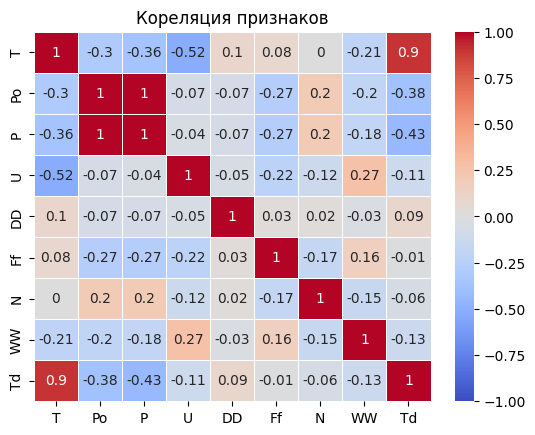

In [ ]:
# корреляция
corrP = df.corr(method='pearson', numeric_only=True).round(2)
sbn.heatmap(corrP, annot=True, vmax=1, vmin=-1, center=0, cmap='coolwarm', linewidths=0.5).set_title('Кореляция признаков')
plt.show()

In [ ]:
# тест Дики-Фуллера
from statsmodels.tsa.stattools import adfuller

for col in df.columns:
    result = adfuller(df[col])
    print(col, '\t| ADF Statistic: %f' % result[0], '\t| p-value: %f' % result[1])

T 	| ADF Statistic: -4.529007 	| p-value: 0.000174
Po 	| ADF Statistic: -13.947429 	| p-value: 0.000000
P 	| ADF Statistic: -13.567644 	| p-value: 0.000000
U 	| ADF Statistic: -9.194522 	| p-value: 0.000000
DD 	| ADF Statistic: -19.999600 	| p-value: 0.000000
Ff 	| ADF Statistic: -17.200115 	| p-value: 0.000000
N 	| ADF Statistic: -16.307318 	| p-value: 0.000000
WW 	| ADF Statistic: -14.405210 	| p-value: 0.000000
Td 	| ADF Statistic: -5.561024 	| p-value: 0.000002


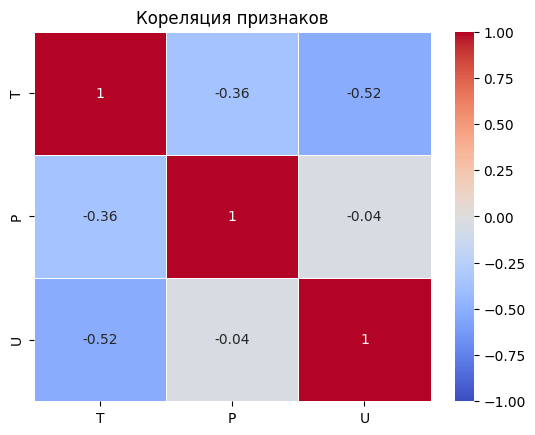

In [ ]:
tmp = ['Po', 'N', 'Td', 'WW', 'DD', 'Ff']
df = df.drop(columns=tmp)
corrP = df.corr(method='pearson', numeric_only=True).round(2)
sbn.heatmap(corrP, annot=True, vmax=1, vmin=-1, center=0, cmap='coolwarm', linewidths=0.5).set_title('Кореляция признаков')
plt.show()

In [ ]:
#сводные статистические данные датасета
print(df.describe())

                  T             P             U
count  20912.000000  20912.000000  20912.000000
mean       5.024818    763.179839     68.942569
std       12.559608      8.358217     19.204833
min      -35.300000    730.000000      8.000000
25%       -4.100000    757.600000     57.000000
50%        5.000000    762.700000     75.000000
75%       14.700000    768.200000     84.000000
max       39.100000    794.800000     96.000000


<Axes: ylabel='Count'>

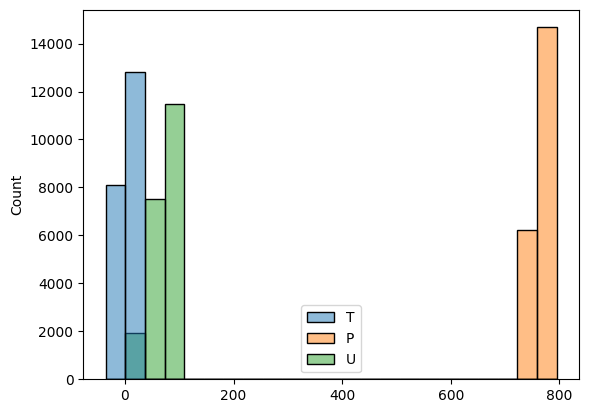

In [ ]:
sbn.histplot(df)

In [ ]:
# График температуры для результирующего датасета
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['T'], name='Суточные значения'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor='center'),
                  title='График температуры',
                  xaxis_title='Температура',
                  yaxis_title="оС",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show(renderer='colab')

Часть 2. Построение прогноза температуры

1. Прогнозирование данных с помощью SARIMA

In [ ]:
# Построение прогноза
import warnings
import itertools

# Определение коэффициентов p, d и q в диапазоне 0-2
p = d = q = range(0, 2)
# Сгенерируем различные комбинации p, q и q
pdq = list(itertools.product(p, d, q))
# Сгенерируем комбинации сезонных параметров p, q и q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
# Функция поиска наилучшей комбинации коэффициентов. Минимальное значение AIC
def find_aic(s_df, pdq):
    warnings.filterwarnings('ignore')
    pdq_res = []
    k = 1000000000
    kk = 0
    min_param = ''
    min_season = ''
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                tmp_model = sm.tsa.statespace.SARIMAX(s_df,
                                                      order=param,
                                                      seasonal_order=param_seasonal,
                                                      enforce_stationarity=False,
                                                      enforce_invertibility=False)
                tmp_model = tmp_model.fit()
                if tmp_model.aic < k:
                    k = tmp_model.aic
                    min_param = param
                    min_season = param_seasonal
                #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    pdq_res.append(min_param)
    pdq_res.append(min_season)
    return pdq_res

In [ ]:
# усредним значений до суточных
df_learn = df
df_learn = df_learn.resample('D').mean()
df_learn = df_learn.ffill()

In [ ]:
# поделим выборку на обучающую и тестовую
train_data, test_data = train_test_split(df_learn, test_size=0.2, shuffle=False)

In [ ]:
import time
start_t = time.time()
arima_param = {}
arima_param['T'] = find_aic(pd.DataFrame(train_data['T']), pdq)
print('Наилучшие гипрепараметры:', arima_param)
print('Время подбора параметров:', str(round((time.time()-start_t)/60, 2)), 'минут')

Наилучшие гипрепараметры: {'T': [(1, 0, 1), (1, 1, 1, 12)]}
Время подбора параметров: 1.07 минут


In [ ]:
# создадим модель для прогноза температурных значений истроических данных по температуре
sar_model_T = sm.tsa.statespace.SARIMAX(train_data['T'],
                                        order=arima_param['T'][0],
                                        seasonal_order=arima_param['T'][1],
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
sar_model_T = sar_model_T.fit()
print('Параметры модели "sar_model_T"', '\n', sar_model_T.summary())

Параметры модели "sar_model_T" 
                                      SARIMAX Results                                      
Dep. Variable:                                  T   No. Observations:                 2108
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -5421.619
Date:                            Sun, 19 Nov 2023   AIC                          10853.238
Time:                                    16:36:06   BIC                          10881.443
Sample:                                09-01-2016   HQIC                         10863.573
                                     - 06-09-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9441      0.007    131.306      0.000       0.930       0.958
ma

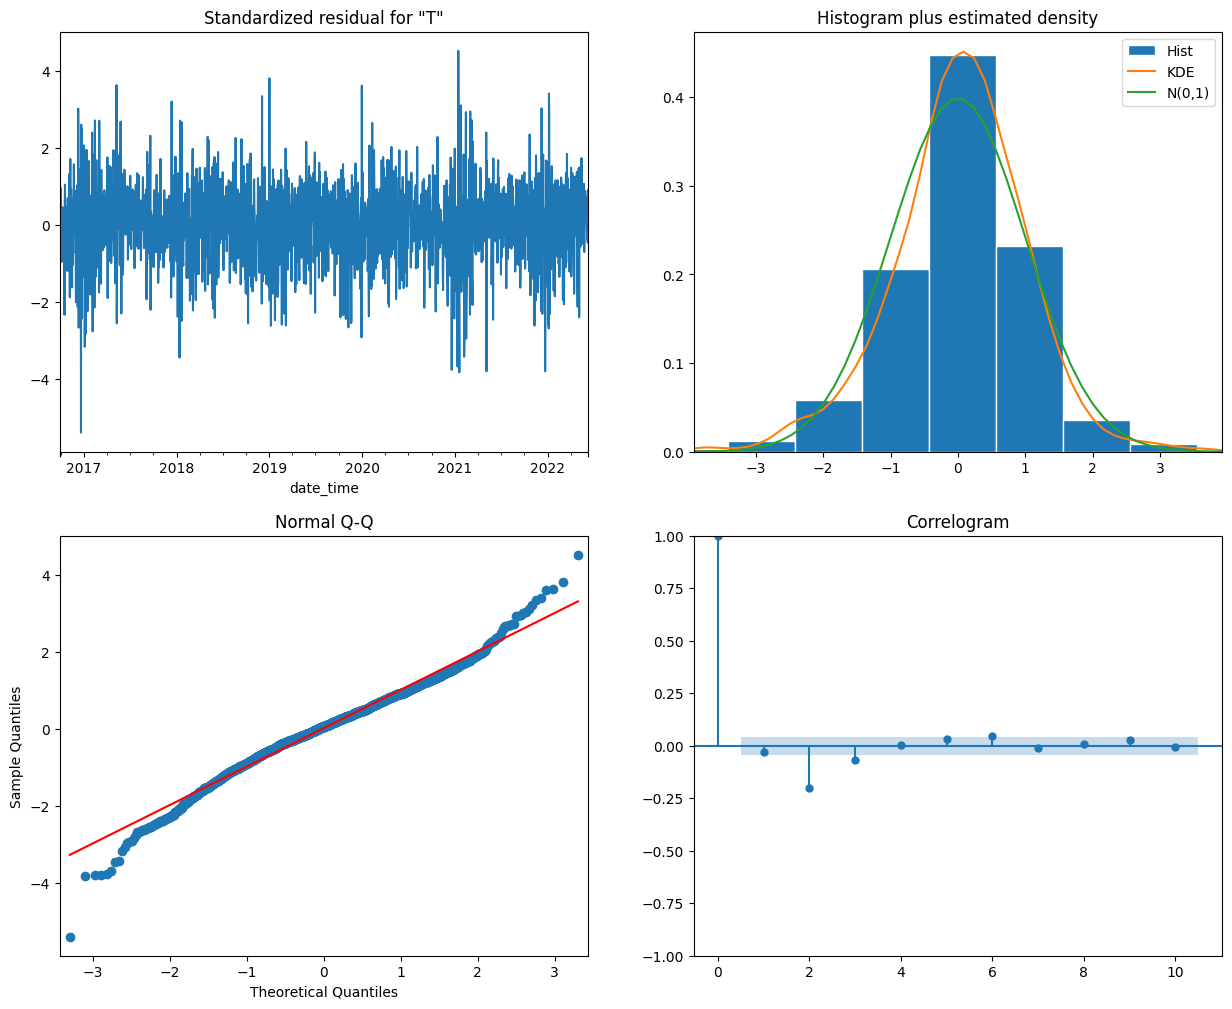

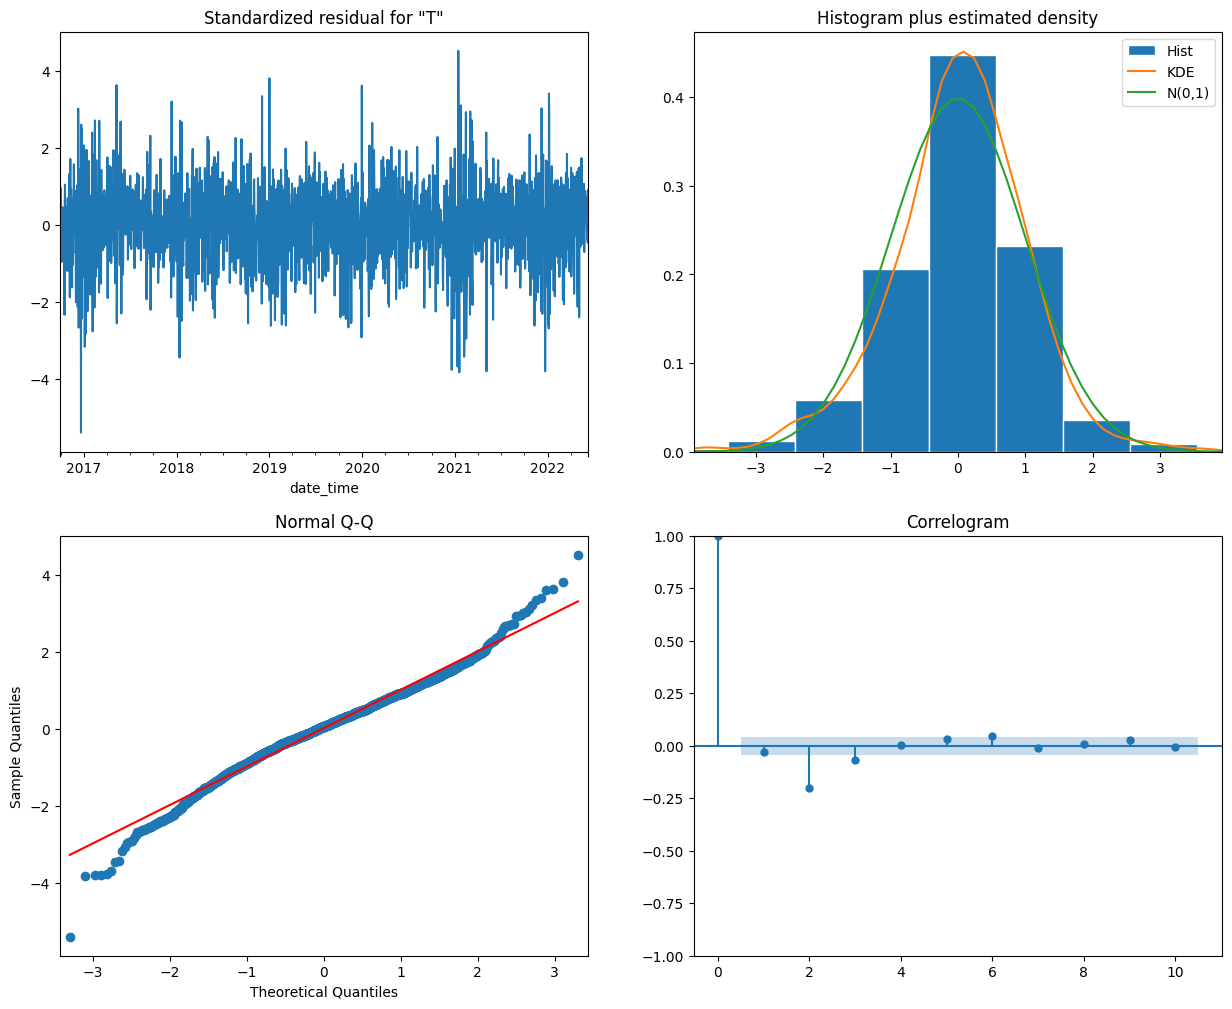

In [ ]:
sar_model_T.plot_diagnostics(figsize=(15, 12))

In [ ]:
# сохраним модель для последующего использования
sar_model_T.save('sar_model_T.pkl')

In [ ]:
# прогнозирование параметров
pred_df = pd.DataFrame()
pred = sar_model_T.get_prediction(start=test_data.index[0],
                                        end=pd.to_datetime(str(test_data.index[-1] + dt.timedelta(days=7))),
                                        dynamic=False)
pred_ci = pred.conf_int()
pred_df['T'] = pd.Series(pred.predicted_mean).array
pred_df.index = pred_ci.index
pred_df.index.name = 'date_time'

In [ ]:
# Оценка качества модели
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(test_data['T'], pred.predicted_mean[:-7])
r2 = r2_score(test_data['T'], pred.predicted_mean[:-7])

print("MSE: ", round(mse, 4))
print("R^2: ", round(r2, 4))

MSE:  151.814
R^2:  -0.0656


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_learn.index, y=df_learn['T'], name='Суточные значения'))
fig.add_trace(go.Scatter(x=pred_ci.index, y=pred.predicted_mean, name='Прогноз'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Прогноз температуры",
                  xaxis_title="Температура",
                  yaxis_title="оС",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show(renderer='colab')

2. Прогнозирование с помощью модели Catboost

In [ ]:
# Разделим данные на обучающую и тестовую выборки (без усреднения до суточных)
train_data, test_data = train_test_split(df, test_size=0.15, shuffle=False)

# Разделение признаков и целевой переменной
y_train = train_data['T']
X_train = train_data.drop('T', axis=1)
y_test = test_data['T']
X_test = test_data.drop('T', axis=1)

In [ ]:
# функция подбора оптимальных параметров для модели
def find_param(trial):
    params = {
        "iterations": 2000,
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "loss_function": "RMSE",
        "random_seed": trial.suggest_int("random_seed", 1, 30),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "grow_policy": 'Depthwise',
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 5.0),
        "score_function": 'L2',
    }
    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return rmse

In [ ]:
# Подбор параметров модели
start = time.time()
study = optuna.create_study(direction='minimize')
study.optimize(find_param, n_trials=500)
print('Наилучшие гиперпараметры:', study.best_params)
print('RMSE:', study.best_value)
print('Время обучения:', str(round((time.time() - start)/60)), 'минут')

[I 2023-11-19 16:38:28,994] A new study created in memory with name: no-name-fe9d6e65-acf2-4b70-8299-de75f26699a9
[I 2023-11-19 16:38:38,377] Trial 0 finished with value: 8.095709792033407 and parameters: {'learning_rate': 0.002112150484215049, 'depth': 3, 'subsample': 0.30885516010964764, 'colsample_bylevel': 0.6819520284419092, 'random_seed': 12, 'min_data_in_leaf': 22, 'l2_leaf_reg': 4.79622303326825}. Best is trial 0 with value: 8.095709792033407.
[I 2023-11-19 16:38:40,617] Trial 1 finished with value: 8.17332263018968 and parameters: {'learning_rate': 0.012658339751515918, 'depth': 1, 'subsample': 0.38493076066754084, 'colsample_bylevel': 0.35411880091364467, 'random_seed': 29, 'min_data_in_leaf': 43, 'l2_leaf_reg': 3.435970133653374}. Best is trial 0 with value: 8.095709792033407.
[I 2023-11-19 16:38:55,376] Trial 2 finished with value: 8.154687739679911 and parameters: {'learning_rate': 0.008157315262982525, 'depth': 9, 'subsample': 0.294893677616496, 'colsample_bylevel': 0.937

Наилучшие гиперпараметры: {'learning_rate': 0.010993944244630016, 'depth': 2, 'subsample': 0.09216631854738151, 'colsample_bylevel': 0.7333308982796034, 'random_seed': 8, 'min_data_in_leaf': 31, 'l2_leaf_reg': 3.0190136110846595}
RMSE: 7.954666790839902
Время обучения: 46 минут


In [ ]:
# обучение модели по лучшим параметрам
cb_model = CatBoostRegressor(iterations=2000,
                          learning_rate=study.best_params['learning_rate'],
                          depth=study.best_params['depth'],
                          subsample=study.best_params['subsample'],
                          colsample_bylevel=study.best_params['colsample_bylevel'],
                          loss_function='RMSE',
                          random_seed=study.best_params['random_seed'],
                          min_data_in_leaf=study.best_params['min_data_in_leaf'],
                          grow_policy='Depthwise',
                          l2_leaf_reg=study.best_params['l2_leaf_reg'],
                          score_function='L2',
                         )
cb_model = cb_model.fit(X_train, y_train, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
# Прогнозирование значений
cb_predictions = cb_model.predict(X_test)
pred = pd.DataFrame()
pred.index = test_data.index
pred['T'] = cb_predictions

In [ ]:
# Оценка качества модели
mse = mean_squared_error(y_test, cb_predictions)
r2 = r2_score(y_test,cb_predictions)

print("MSE: ", round(mse, 4))
print("R^2: ", round(r2, 2))

MSE:  63.2767
R^2:  0.6108


In [ ]:
# сохраним модель для последующего использования
cb_model.save_model('cb_model',
           format="cbm",
           export_parameters=None,
           pool=None)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['T'], name='Суточные значения'))
fig.add_trace(go.Scatter(x=pred.index, y=pred['T'], name='Прогноз', opacity=0.85))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Прогноз температуры (модель Catboost)",
                  xaxis_title="Температура",
                  yaxis_title="оС",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show(renderer='colab')

In [ ]:
# определим наилучшие гиперпараметры для кажгого признака
start_t = time.time()
arima_param = {}
for col in df_learn.columns:
    if col != 'T':
        arima_param[col] = find_aic(pd.DataFrame(df_learn[col]), pdq)
print('Наилучшие гипрепараметры:', arima_param)
print('Время подбора параметров:', str((time.time()-start_t)/60))



# создание моделй для каждого параметра
models = ['mod_P', 'mod_U']
for mod in models:
    tmp_mod = sm.tsa.statespace.SARIMAX(pd.DataFrame(df_learn[mod[4:]]),
                                        order=arima_param[mod[4:]][0],
                                        seasonal_order=arima_param[mod[4:]][1],
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
    globals()[mod] = tmp_mod.fit()
    print(mod, '\n', globals()[mod].summary())

Наилучшие гипрепараметры: {'P': [(1, 0, 1), (0, 1, 1, 12)], 'U': [(1, 1, 1), (0, 1, 1, 12)]}
Время подбора параметров: 3.4725189169247943
mod_P 
                                      SARIMAX Results                                      
Dep. Variable:                                  P   No. Observations:                 2635
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood               -7398.181
Date:                            Sun, 19 Nov 2023   AIC                          14804.361
Time:                                    17:29:44   BIC                          14827.828
Sample:                                09-01-2016   HQIC                         14812.863
                                     - 11-18-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------

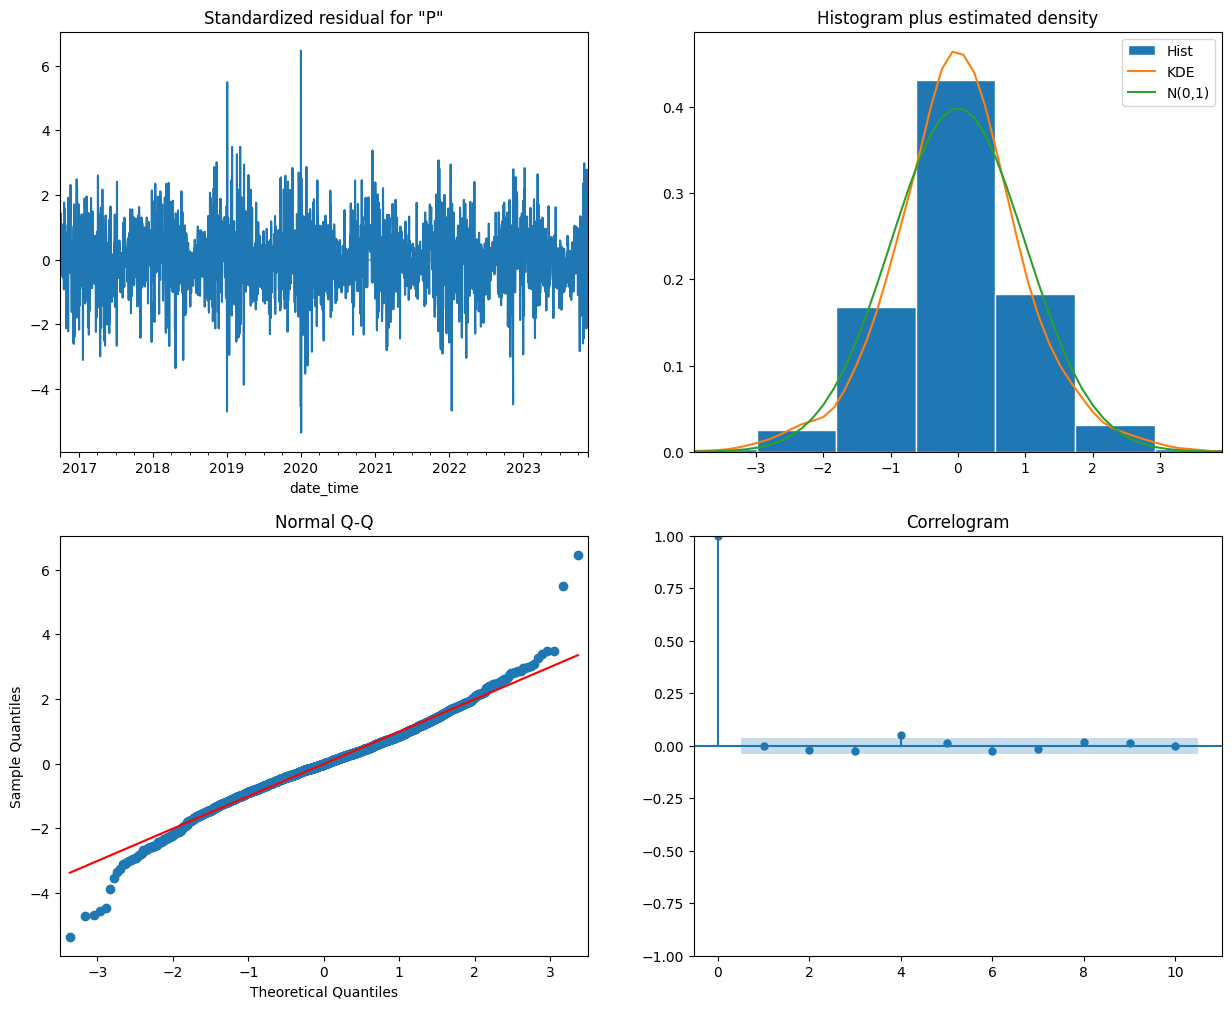

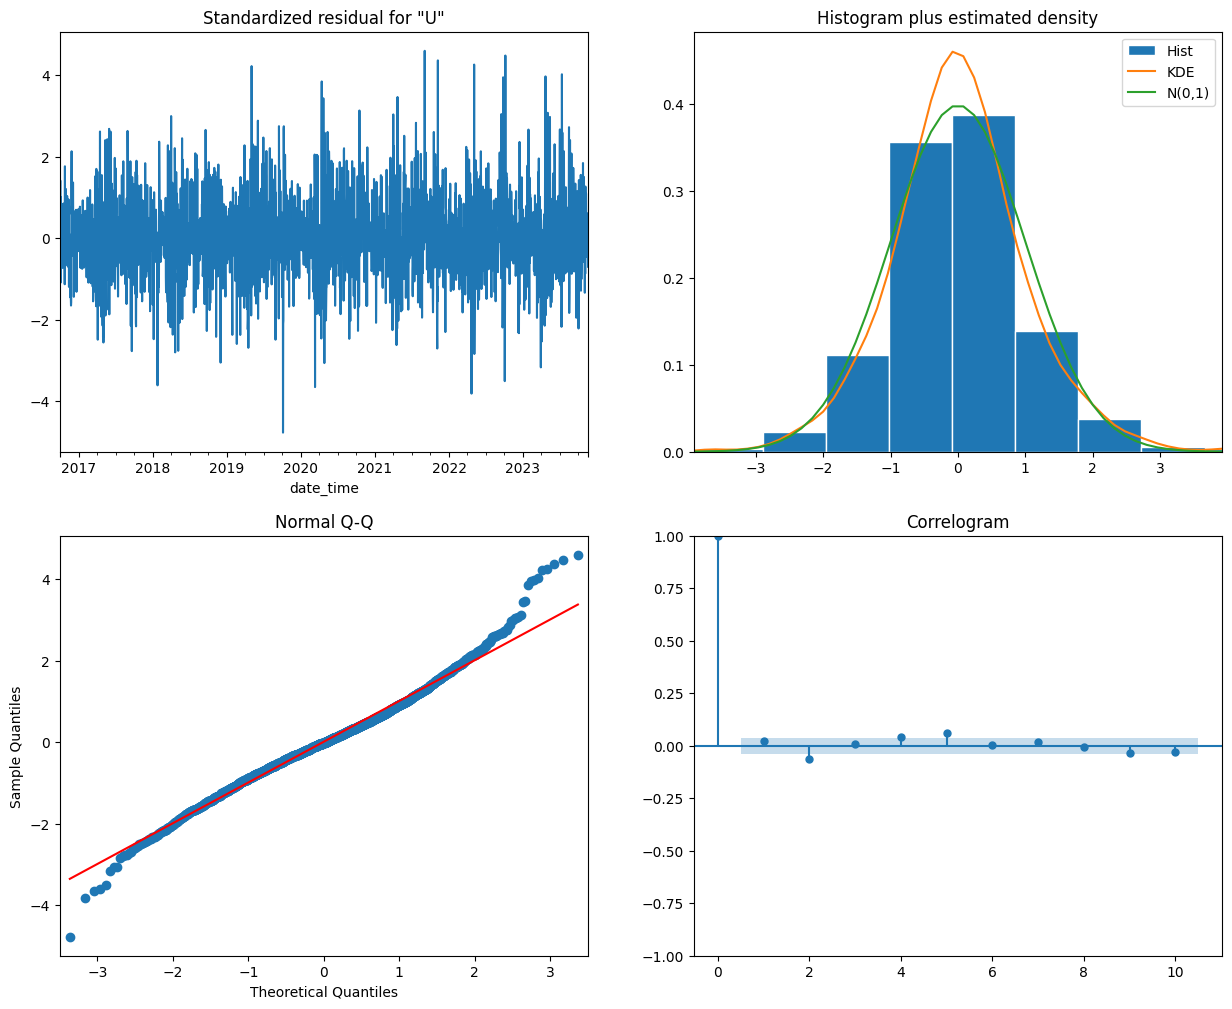

In [ ]:
for mod in models:
    globals()[mod].plot_diagnostics(figsize=(15, 12))

In [ ]:
# прогнозирование параметров SARIMA
pred_df = pd.DataFrame()
for mod in models:
    pred = globals()[mod].get_prediction(start=str(df_learn[models[0][4:]][-31:-30].index[0])[:-9],
                                           end=pd.to_datetime(str(dt.date.today() + dt.timedelta(days=7))),
                                           dynamic=False)
    pred_ci = pred.conf_int()
    pred_df[mod[4:]] = pd.Series(pred.predicted_mean).array
pred_df.index = pred_ci.index
pred_df.index.name = 'date_time'

In [ ]:
# Загрузим модель catboost
model = CatBoostRegressor()
model.load_model('cb_model', format='cbm')

In [ ]:
# спрогнозируем температуру
cb_predict_T = model.predict(pred_df)
pred_T = pd.DataFrame()
pred_T.index = pred_df.index
pred_T['T'] = cb_predict_T

In [ ]:
# Оценка качества модели
mse = mean_squared_error(df_learn['T'][-31:], pred_T['T'][:-8])
r2 = r2_score(df_learn['T'][-31:], pred_T['T'][:-8])

print("MSE: ", round(mse, 4))
print("R^2: ", round(r2, 2))

MSE:  16.9862
R^2:  -0.39


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_learn.index, y=df_learn['T'], name='Суточные значения'))
fig.add_trace(go.Scatter(x=pred_T.index, y=pred_T['T'], name='Прогноз'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Прогноз температуры",
                  xaxis_title="Температура",
                  yaxis_title="оС",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show(renderer='colab')